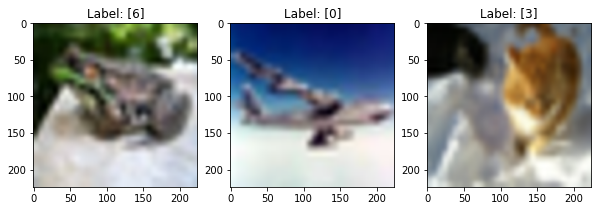

In [30]:
import numpy as np
from PIL import Image
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

# 載入資料集
(train_Data, train_Label), (test_Data, test_Label) = cifar10.load_data()

# 指定亂數種子
seed = 10
np.random.seed(seed)
# 打亂 2 個 Numpy 陣列
def randomize(a, b):
    permutation = np.random.permutation(b.shape[0])
    shuffled_a = a[permutation,:,:]
    shuffled_b = b[permutation]
    return shuffled_a, shuffled_b
    
# 將資料集打散
train_Data, train_Label = randomize(train_Data, train_Label)
# 取出部分的訓練資料
train_Data = train_Data[:5000]
train_Label = train_Label[:5000]
# 取出部分測試集的資料
test_Data = test_Data[:1000]
test_Label = test_Label[:1000]

# 將訓練資料的圖片尺寸放大 (ResNet50 輸入預設是 224x224)
train_Data_new = np.array(
  [np.asarray(Image.fromarray(train_Data[i]).resize(
          (224, 224))) for i in range(0, len(train_Data))])

# 將測試資料的圖片尺寸放大 (ResNet50 輸入預設是 224x224)
test_Data_new = np.array(
  [np.asarray(Image.fromarray(test_Data[i]).resize(
          (224, 224))) for i in range(0, len(test_Data))])

# 繪出3張圖片
fig = plt.figure(figsize=(10,7))
sub_plot= 230
for i in range(0, 3):
    ax = plt.subplot(sub_plot+i+1)
    ax.imshow(train_Data_new[i], cmap="binary")
    ax.set_title("Label: " + str(train_Label[i]))

plt.show()

In [31]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# One-hot編碼
train_Label = to_categorical(train_Label, 10)
test_Label = to_categorical(test_Label, 10)
# 載入 ResNet50 模型
resnet_model = ResNet50(weights="imagenet",
                        include_top=False,
                        input_shape=(224, 224, 3))
print(resnet_model.summary())

# 訓練資料的資料前處理 
train_Data_new = train_Data_new.astype("float32")
preprocess_train_input = preprocess_input(train_Data_new)
print(train_Data_new.shape) 
# 測試資料的資料前處理
test_Data_new = test_Data_new.astype("float32")
preprocess_test_input = preprocess_input(test_Data_new)
print(test_Data_new.shape) 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

(5000, 224, 224, 3)
(1000, 224, 224, 3)


In [33]:
# 使用 ResNet50 模型預測訓練資料的特徵資料
train_features = resnet_model.predict(preprocess_train_input)
print(train_features.shape) 
# 使用 ResNet50 模型預測測試資料的特徵資料
test_features = resnet_model.predict(preprocess_test_input)
print(test_features.shape) 

(5000, 7, 7, 2048)
(1000, 7, 7, 2048)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# 定義模型(加入分類神經網路)
model = Sequential()
model.add(GlobalAveragePooling2D(
        input_shape=train_features.shape[1:]))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [34]:
# 編譯模型
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
# 訓練模型
history = model.fit(train_features, train_Label,
                    validation_data=(test_features, test_Label), 
                    epochs=14, batch_size=32, verbose=2)

Epoch 1/14
157/157 - 5s - loss: 1.0945 - accuracy: 0.6498 - val_loss: 0.4255 - val_accuracy: 0.8580
Epoch 2/14
157/157 - 1s - loss: 0.4804 - accuracy: 0.8338 - val_loss: 0.3513 - val_accuracy: 0.8820
Epoch 3/14
157/157 - 1s - loss: 0.3843 - accuracy: 0.8658 - val_loss: 0.3248 - val_accuracy: 0.8860
Epoch 4/14
157/157 - 1s - loss: 0.3310 - accuracy: 0.8850 - val_loss: 0.3214 - val_accuracy: 0.8950
Epoch 5/14
157/157 - 1s - loss: 0.3168 - accuracy: 0.8930 - val_loss: 0.3099 - val_accuracy: 0.8940
Epoch 6/14
157/157 - 1s - loss: 0.2736 - accuracy: 0.8992 - val_loss: 0.3232 - val_accuracy: 0.8890
Epoch 7/14
157/157 - 1s - loss: 0.2621 - accuracy: 0.9074 - val_loss: 0.3276 - val_accuracy: 0.8840
Epoch 8/14
157/157 - 1s - loss: 0.2271 - accuracy: 0.9196 - val_loss: 0.3005 - val_accuracy: 0.8960
Epoch 9/14
157/157 - 1s - loss: 0.2327 - accuracy: 0.9162 - val_loss: 0.3174 - val_accuracy: 0.8930
Epoch 10/14
157/157 - 1s - loss: 0.2332 - accuracy: 0.9144 - val_loss: 0.3301 - val_accuracy: 0.8910

In [35]:
loss, accuracy = model.evaluate(test_features, Y_test, verbose=0)
print("測試資料集的準確度 = {:.2f}".format(accuracy))

測試資料集的準確度 = 0.90
